In [15]:
# Import necessary libraries
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
import numpy as np
import os
import pandas as pd

# # Load your custom pre-trained model
# model_path = '../models/brain_img_classifier_2.h5'
# model = load_model(model_path)

# Function to preprocess and predict
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Assuming same preprocessing as VGG16

    predictions = model.predict(img_array)
    # Modify this part according to how your model's output should be interpreted
    # print(f'{img_path} Predicted:', predictions)
    return [img_path, predictions[0][0]]

def scrape_images_from_dir(dir_path="../downloaded_pdfs"):
    path_list = []
    for subdir, _, files in os.walk(dir_path):
        for filename in files:
            if filename.endswith((".jpg", ".png", ".jpeg")):
                path_list.append(os.path.join(subdir, filename))
    return path_list

# results = [predict_image(path) for path in scrape_images_from_dir()]

# df = pd.DataFrame(results, columns=['path', 'prediction'])

# with open('predictions.csv', 'w') as f:
#     df.to_csv(f, index=False)


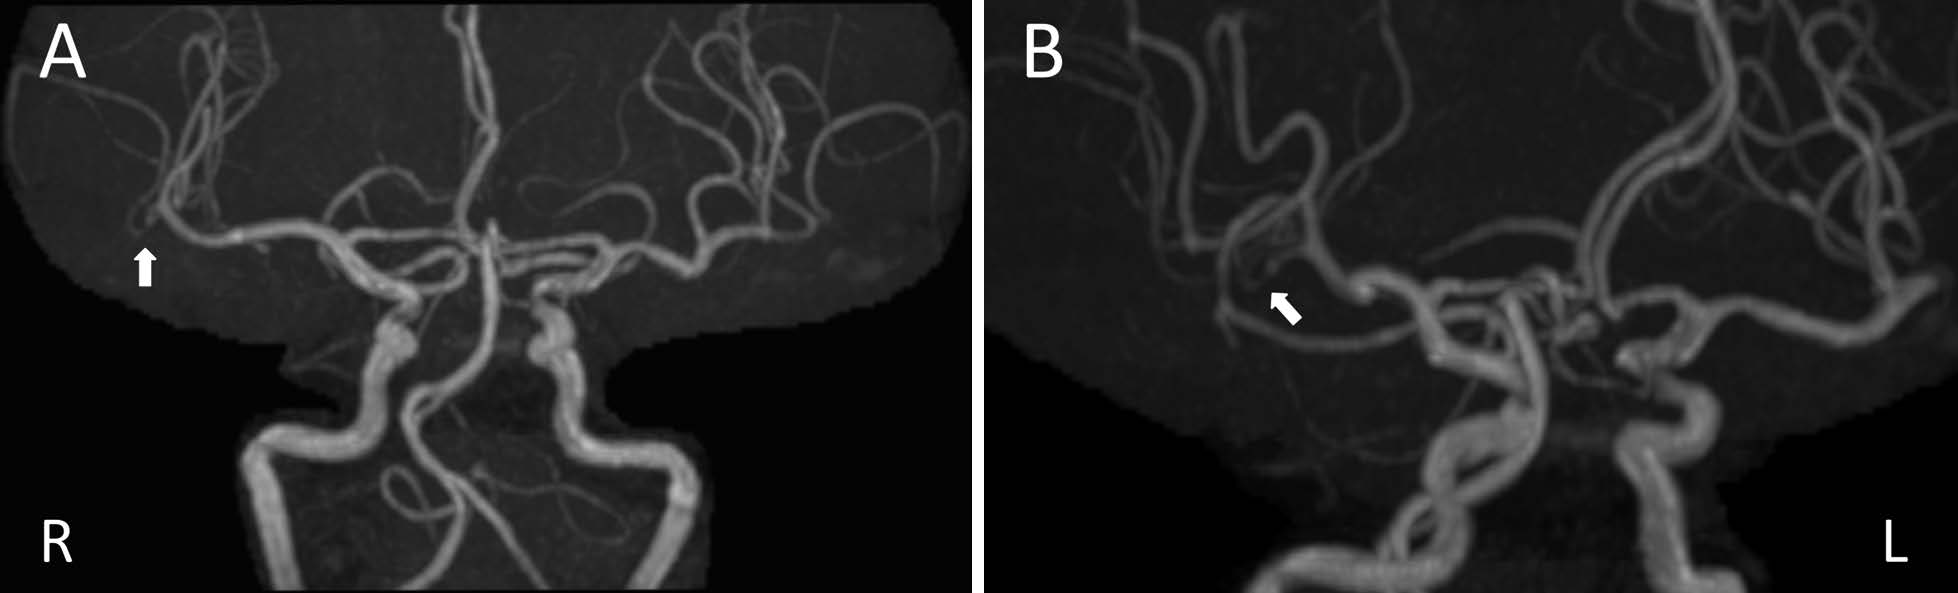

Button(description='Yes', style=ButtonStyle())

Button(description='No', style=ButtonStyle())

Label set to 0 for index 182
All images have been labeled.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, Image, clear_output, HTML
import base64

label_df = df.copy()
label_df['label'] = [None] * len(label_df)

def image_html_with_max_size(image_path, max_size=400):
    # Read the image and encode it in base64
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()

    # Create an HTML image tag with max-width and max-height styling
    image_html = f'<img src="data:image/png;base64,{encoded_string}" style="max-width:{max_size}px; max-height:{max_size}px;"/>'
    return image_html

# Function to display image and buttons for a specific row
def label_data(df_index):
    # Check if the current index is the last one
    if df_index >= len(label_df):
        print("All images have been labeled.")
        return

    # Clear previous outputs
    clear_output(wait=True)

    image_path = label_df.iloc[df_index, 0]
    image_html = image_html_with_max_size(image_path)
    display(HTML(image_html))

    # Create Yes and No buttons
    button_yes = widgets.Button(description="Yes")
    button_no = widgets.Button(description="No")

    # Function to handle button click
    def on_button_clicked(b):
        # Update label in DataFrame
        label_df.at[df_index, 'label'] = 1 if b.description == "Yes" else 0
        print(f"Label set to {label_df.at[df_index, 'label']} for index {df_index}")

        # Automatically move to the next image if it's not the last one
        if df_index + 1 < len(label_df):
            label_data(df_index + 1)
        else:
            print("All images have been labeled.")

    # Register the event handler
    button_yes.on_click(on_button_clicked)
    button_no.on_click(on_button_clicked)

    # Display the buttons
    display(button_yes, button_no)

# Example usage
label_data(0)  # Start with the first row

In [18]:
def scrape_images_from_dir(dir_path="../downloaded_pdfs", max_images=1000000):
    path_list = []
    for subdir, _, files in os.walk(dir_path):
        for filename in files:
            if filename.endswith((".jpg", ".png", ".jpeg")):
                path_list.append(os.path.join(subdir, filename))
            if len(path_list) >= max_images:
                return path_list
    return path_list

full_label_df = label_df.copy()

# Add the other labeled data to the DataFrame
positive_data_path = "../all_brain_images/manual_label"
negative_data_path = "../all_non_brain/manual_label"
brain_tumor_data_path = "../all_brain_images/tumor_dataset/"
lung_ct_path = "../all_non_brain/ct_scans/"

# Add the positive data to labels_df (path, prediction, label)
positive_paths = scrape_images_from_dir(positive_data_path)
positive_df = pd.DataFrame(positive_paths, columns=['path'])
positive_df['prediction'] = 1
positive_df['label'] = 1

# Add the negative data to labels_df (path, prediction, label)
negative_paths = scrape_images_from_dir(negative_data_path)
negative_df = pd.DataFrame(negative_paths, columns=['path'])
negative_df['prediction'] = 0
negative_df['label'] = 0

# Add the brain tumor data as positive data, but only include the first 150 images
brain_tumor_paths = scrape_images_from_dir(brain_tumor_data_path, max_images=150)
brain_tumor_df = pd.DataFrame(brain_tumor_paths, columns=['path'])
brain_tumor_df['prediction'] = 1
brain_tumor_df['label'] = 1

# Add the lung CT data as negative data, but only include the first 150 images
lung_ct_paths = scrape_images_from_dir(lung_ct_path, max_images=150)
lung_ct_df = pd.DataFrame(lung_ct_paths, columns=['path'])
lung_ct_df['prediction'] = 0
lung_ct_df['label'] = 0

# Combine the DataFrames
full_label_df = pd.concat([full_label_df, positive_df, negative_df, brain_tumor_df, lung_ct_df], ignore_index=True)

# display(full_label_df)

In [19]:
# My question is how does the model know which data is positive and which is negative? 
# The data is labeled in the dataframe as 1 or 0 in the label column.
# But, do we tell the model that 1 is positive and 0 is negative?

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

# Assuming 'df' is your DataFrame with 'path' and 'label' columns
full_label_df['label'] = full_label_df['label'].astype(str)
train_df, test_df = train_test_split(full_label_df, test_size=0.2, random_state=42)  # Split into train and test
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # Split train into train and validation (0.6 train, 0.2 val, 0.2 test)

# Data augmentation for the training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG16 preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Only rescaling for the validation and test data
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data generators for train, validation, and test sets using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 740 validated image filenames belonging to 2 classes.
Found 247 validated image filenames belonging to 2 classes.
Found 247 validated image filenames belonging to 2 classes.


In [20]:
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications import VGG16

def create_or_finetune_vgg16(   pre_trained_model_path=None,
                                num_custom_layers=4, input_shape=(224, 224, 3),
                                num_epochs=10, train_generator=None,
                                validation_generator=None,
                                test_generator=None,
                                save_path='../models/brain_img_classifier_fine_tuned.h5'):
    if pre_trained_model_path:
        # Load the pre-trained model
        model = load_model(pre_trained_model_path)

        # Freeze all layers except the last 'num_custom_layers'
        for layer in model.layers[:-num_custom_layers]:
            layer.trainable = False
    else:
        # Load the VGG16 base model
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

        # Freeze the layers of the base model
        for layer in base_model.layers:
            layer.trainable = False

        # Create a new model on top of the base model
        model = Sequential([
            base_model,
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    if train_generator and validation_generator:
        model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // train_generator.batch_size,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // validation_generator.batch_size,
            epochs=num_epochs
        )

    # Evaluate the model
    if test_generator:
        test_loss, test_accuracy = model.evaluate(test_generator)
        print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

    # Save the model
    model.save(save_path)

    return model

# Usage Example

pre_trained_model_path = None  # Path to pre-trained model (e.g. '../models/brain_img_classifier_2.h5')
# pre_trained_model_path = '../models/brain_img_classifier_2.h5'
new_model_path = '../models/brain_img_classifier_fine_tuned_2.h5'

model = create_or_finetune_vgg16(
    pre_trained_model_path=pre_trained_model_path,
    num_custom_layers=4,  # Number of custom layers you added
    num_epochs=20,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
    save_path=new_model_path
)


Epoch 1/20
23/23 [==============================] - 90s 4s/step - loss: 4.9056 - accuracy: 0.8588 - val_loss: 4.1959 - val_accuracy: 0.9241
Epoch 2/20
23/23 [==============================] - 96s 4s/step - loss: 2.0155 - accuracy: 0.9393 - val_loss: 3.4357 - val_accuracy: 0.9241
Epoch 3/20
23/23 [==============================] - 96s 4s/step - loss: 1.6378 - accuracy: 0.9308 - val_loss: 2.9837 - val_accuracy: 0.9196
Epoch 4/20
23/23 [==============================] - 95s 4s/step - loss: 1.6664 - accuracy: 0.9407 - val_loss: 2.1745 - val_accuracy: 0.9420
Epoch 5/20
23/23 [==============================] - 96s 4s/step - loss: 1.3695 - accuracy: 0.9449 - val_loss: 1.7286 - val_accuracy: 0.9420
Epoch 6/20
23/23 [==============================] - 98s 4s/step - loss: 0.7704 - accuracy: 0.9548 - val_loss: 0.6782 - val_accuracy: 0.9375
Epoch 7/20
23/23 [==============================] - 96s 4s/step - loss: 0.4985 - accuracy: 0.9590 - val_loss: 1.9063 - val_accuracy: 0.9286
Epoch 8/20
23/23 [==

c:\Users\josep\miniconda3\envs\brain_classifier_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
